**Welcome to Programming Assignment 4  on Deep Learning for Computer Vision.**



#### **Instructions**
1. Use Python 3.x to run this notebook
2. Write your code only in between the lines 'YOUR CODE STARTS HERE' and 'YOUR CODE ENDS HERE'. You should not change anything else in the code cells. If you do, the answers you are supposed to get at the end of this assignment might be wrong.
3. Read documentation of each function carefully.
4. All the Best!

In [1]:
# Please DO NOT modify this cell.

import os
import os.path as osp
import random

import numpy as np
import torch

import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data.sampler import BatchSampler
from torch.optim import lr_scheduler
from PIL import Image
import timeit
from torchvision.datasets import MNIST
from torchvision import transforms
import cv2
from google.colab.patches import cv2_imshow


def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)



We will compute the integral image of a given gray scale image and use it to find integral of an image patch.

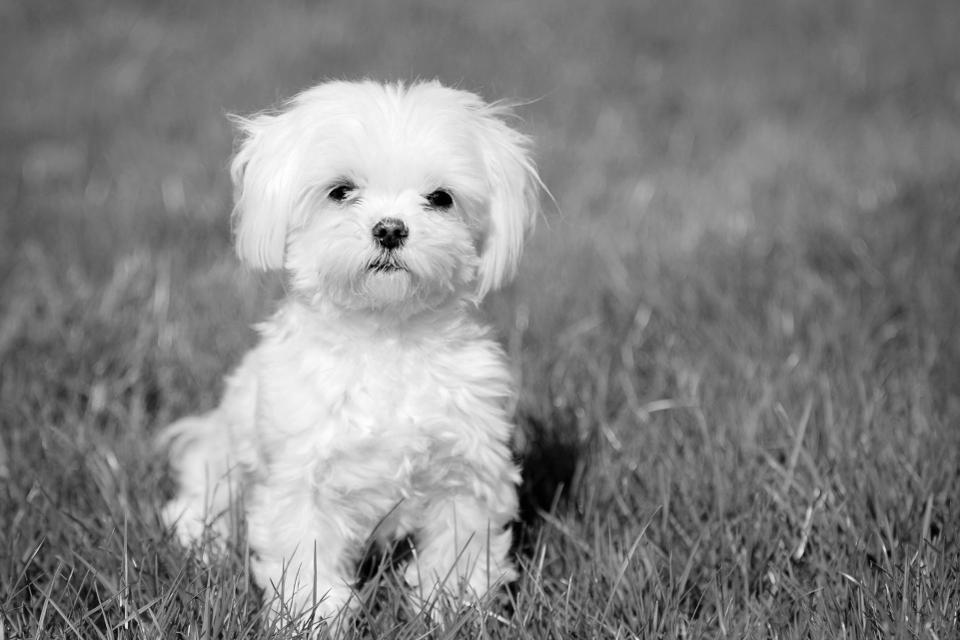

In [2]:
img = cv2.imread('image.jpg', 0)
cv2_imshow(img)

In [3]:
h, w = img.shape  # Get the height and width of the image

img_arr = np.array(img, dtype='int64')  # Convert the image to a NumPy array with integer values

# Initializing the row sum and integral image arrays
s = np.zeros((h, w))  # Array to store the cumulative row sums
ii = np.zeros((h, w))  # Array to store the integral image

#### YOUR CODE STARTS HERE ####

# Define a function to populate the row sum array `s` based on `img_arr`
def populate_row_sum():
    for x in range(h):  # Iterate over each row
        s[x][0] = img_arr[x][0]  # Initialize the first element of each row
        for y in range(1, w):  # Iterate over each column starting from the second
            s[x][y] = s[x][y-1] + img_arr[x][y]  # Update the row sum by adding the current element

# Define a function to populate the integral image array `ii` based on `s`
def populate_integral_image():
    for y in range(w):  # Initialize the first row of the integral image
        ii[0][y] = s[0][y]
    for x in range(1, h):  # Iterate over each row starting from the second
        for y in range(w):  # Iterate over each column
            ii[x][y] = ii[x-1][y] + s[x][y]  # Update the integral image by adding the row sum to the value above

# Define a function to find the region sum in the image given upper left pixel coordinate (x1, y1)
# and bottom right pixel coordinate (x2, y2) using the computed arrays `s` and `ii` with appropriate boundary conditions
def region_sum(x1, y1, x2, y2):
    if x2 < 0 or y2 < 0:  # Boundary condition for negative indices
        return 0
    d = ii[x2][y2]  # Value at the bottom-right corner of the region
    a = 0
    if x1 > 0 and y1 > 0:  # Top-left corner adjustment
        a = ii[x1-1][y1-1]
    b = 0
    if x1 > 0:  # Top-right corner adjustment
        b = ii[x1-1][y2]
    c = 0
    if y1 > 0:  # Bottom-left corner adjustment
        c = ii[x2][y1-1]
    return d + a - (b + c)  # Calculate the sum of the region
#### YOUR CODE ENDS HERE ####


In [4]:
populate_row_sum()

populate_integral_image()

print(s[90][50], ii[350][750], region_sum(100, 130, 380, 665))

5313.0 37465641.0 25108243.0


## Question 1:

What are the respective values for the quantities s[90][50], ii[350][750], region_sum(100, 130, 380, 665) ?

1.   2880, 12688949, 13923164
2.   4880, 36188949, 25444096
3.   5313, 37465641, 25108243
4.   7313, 56188949, 46323164




We will implement Multi-Task Loss for Fast R-CNN by extending the nn class of pythorch. Given the predicted logits, one-hot encoding of actual class labels, ground truth bounding box regression targets and predicted bounding box regression offsets it should return the loss value




In [14]:
class MultiTaskLoss(nn.Module):

    def __init__(self, alpha = 0.1):
        super().__init__()
        self.alpha = alpha
        #### YOUR CODE STARTS HERE ####
        # Initialize a SmoothL1Loss function from the nn class of pytorch with the  reduction param as sum for Fast R-CNN
        self.smooth_l1_loss = nn.SmoothL1Loss(reduction='sum')
        #### YOUR CODE ENDS HERE ####

    def forward(self, pred_logits, true_class, bounding_box_offsets, bounding_box_target): # refer the later code for interpretatio of the params
        #### YOUR CODE STARTS HERE ####
        # Calculate predicted class probabilities by taking softmax of predicted logits
        pred = torch.softmax(pred_logits, dim=-1)

        # Calculate the classification loss
        true_class_index = torch.argmax(true_class) #index of the true class
        L_cls = -torch.log(pred[true_class_index])
        # Get the bounding box regression offsets for true class
        t_u = bounding_box_offsets[true_class_index]
        L_loc = 0
        # Calculate localization loss only for non background class
        if true_class_index > 0: # give appropiate condition
          # Calculate the localization loss(smooth L1 loss) between the true bounding box regression targets
          # and the bounding box offsets computed above while applying the smooth_l1_loss function initialised above
          L_loc = self.smooth_l1_loss(t_u, bounding_box_target)

        # Calculate the Multi Task loss from the two losses while using alpha as the scaling factor for the localization loss
        Loss = L_cls + self.alpha * L_loc
        #### YOUR CODE ENDS HERE ####
        return Loss

In [15]:
# create an object of MultiTaskLoss
mt_loss=MultiTaskLoss(alpha = 0.02)

In [16]:
# Assume predicted are the predicted logits
predicted_logits=torch.tensor([1.4315, 2.9862, 0.4019, 1.5501])
#One hot encoding of the true class
true_class=torch.tensor([0., 1., 0., 0.])
# Class wise predicted bounding box offsets
bounding_box_offsets = torch.tensor([[25., 51., 82., 120.],[63., 42., 103., 75.],[158., 26., 94., 56.],[15., 86., 44., 80.]])
# Bounding box regression target
bounding_box_target = torch.tensor([58., 35., 108., 81.])

In [17]:
#Calculate multi task loss based on the above values
#Use the MultiTaskLossMultiTaskLoss object created above
#Print the value
print(mt_loss(predicted_logits,true_class, bounding_box_offsets, bounding_box_target))


tensor(0.8417)


## Question 2:

What is the value of the multi-task loss obtained above ? (Select the nearest value)

1.   0.6317
2.   0.7329
3.   0.9435
4.   0.8417

Dice Loss Implementation

In [18]:
import torch
import torch.nn.functional as F

def dice_loss(pred, target, smooth=1e-6):
    # Flatten the tensors to 1D
    pred_flat = pred.view(-1)
    target_flat = target.view(-1)

    # Compute the intersection and union
    intersection = (pred_flat * target_flat).sum()
    union = pred_flat.sum() + target_flat.sum()

    # Compute the Dice coefficient
    dice_coeff = (2.0 * intersection + smooth) / (union + smooth)

    # Return Dice loss
    return 1 - dice_coeff


In [19]:
set_seed(1)
pred_mask = torch.sigmoid(torch.randn(1, 1, 256, 256))  # Simulated prediction after sigmoid
target_mask = torch.randint(0, 2, (1, 1, 256, 256)).float()  # Simulated binary target mask

loss = dice_loss(pred_mask, target_mask)
print(f"Dice Loss: {loss.item()}")

Dice Loss: 0.5018245577812195


## Question 3:

What is the value of the dice loss obtained above ? (Select the nearest value)

1.   0.5018
2.   0.6324
3.   0.7846
4.   0.8722


We will be fitting an LSTM to a cosine wave.

In [20]:
import matplotlib.pyplot as plt
import torch.nn as nn

Prepare the training and testing dataset.

In [21]:
# Please DO NOT modify this cell.

def get_data():

    train_x = np.arange(0, 100, 0.5)
    train_data = np.cos(train_x)

    test_x = np.arange(100, 200, 0.5)
    test_data = np.cos(test_x)

    return train_x, train_data, test_x, test_data

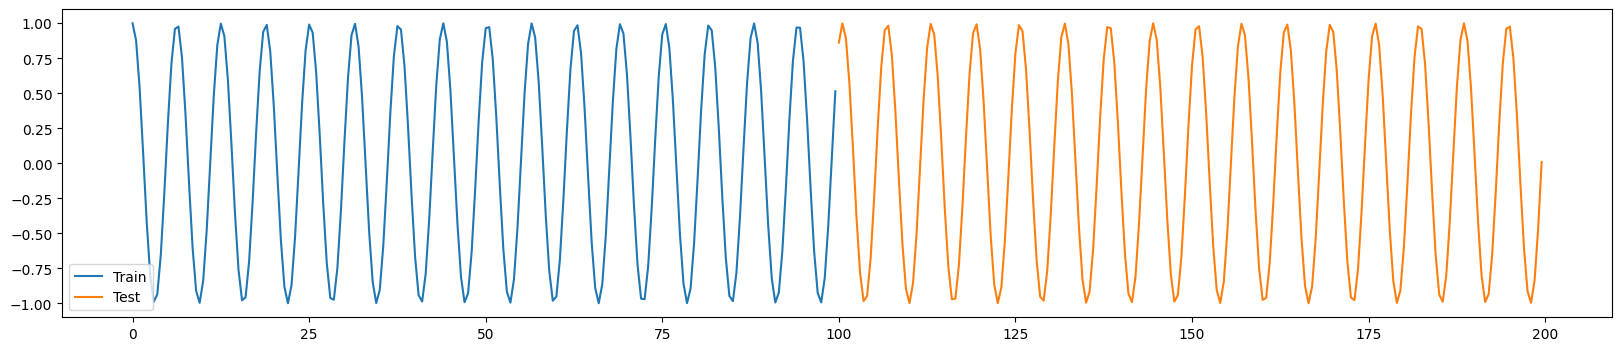

In [22]:
# Please DO NOT modify this cell.

train_x, train_data, test_x, test_data = get_data()

plt.figure(figsize = (20, 4))
plt.plot(train_x, train_data, label = 'Train')
plt.plot(test_x, test_data, label = 'Test')

plt.legend(loc = "lower left")
plt.show()

In [23]:
# Please DO NOT modify this cell.
"""
Functions for creating sliding windows from the data, this is a useful function
to understand for any time-series prediction task
"""

def sliding_windows(data, seq_length):

    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)

In [24]:
# Please DO NOT modify this cell.

"""
Create sliding windows
"""

seq_length = 5
x_train, y_train = sliding_windows(train_data, seq_length)
x_test, y_test = sliding_windows(test_data, seq_length)

x_train = torch.Tensor(x_train)
y_train = torch.Tensor(y_train).reshape(-1, 1)

x_test = torch.Tensor(x_test)
y_test = torch.Tensor(y_test).reshape(-1, 1)

x_train = x_train[:, :, np.newaxis]
x_test = x_test[:, :, np.newaxis]

Create the model

In [25]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size

        #### YOUR CODE STARTS HERE ####

        # Define a LSTM block and a FC block
        # Set batch_first = True

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
        self.fc = nn.Linear(hidden_size, num_classes)

        #### YOUR CODE ENDS HERE ####

    def forward(self, x):

        #### YOUR CODE STARTS HERE ####

        # Propagate input through LSTM
        # Pass the input, hidden state and cell_state

        output, (hidden_out, cell_out) = self.lstm(x)

        # Flatten hidden_out and pass it through fc layer

        hidden_out = hidden_out.view(-1, self.hidden_size)
        out = self.fc(hidden_out)

        #### YOUR CODE ENDS HERE ####

        return out

Training

In [27]:
set_seed(2)
num_epochs = 350
learning_rate = 0.001

input_size = 1
hidden_size = 5
num_layers = 1

num_classes = 1

# Define LSTM model
lstm_model = LSTM(num_classes, input_size, hidden_size, num_layers)

# Set MSE loss as criterion
criterion = torch.nn.MSELoss()

# Use Adam optimizer
optimizer = torch.optim.Adam(lstm_model.parameters(), lr = learning_rate)

# Train the model

for epoch in range(1, num_epochs+1):

    #### YOUR CODE STARTS HERE ####

    # Pass x_train as input to the lstm network
    train_predict = lstm_model(x_train)

    # Clear gradients in the optimizer
    optimizer.zero_grad()

    # Calculate loss using criterion function
    loss = criterion(train_predict, y_train)

    # Calculate gradients with respect to the loss
    loss.backward()

    # Update parameters
    optimizer.step()

    #### YOUR CODE ENDS HERE ####

    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{num_epochs}, loss: {loss.item():.2f}")

Epoch 10/350, loss: 0.73
Epoch 20/350, loss: 0.71
Epoch 30/350, loss: 0.68
Epoch 40/350, loss: 0.66
Epoch 50/350, loss: 0.63
Epoch 60/350, loss: 0.61
Epoch 70/350, loss: 0.59
Epoch 80/350, loss: 0.58
Epoch 90/350, loss: 0.56
Epoch 100/350, loss: 0.54
Epoch 110/350, loss: 0.53
Epoch 120/350, loss: 0.51
Epoch 130/350, loss: 0.50
Epoch 140/350, loss: 0.48
Epoch 150/350, loss: 0.47
Epoch 160/350, loss: 0.46
Epoch 170/350, loss: 0.44
Epoch 180/350, loss: 0.43
Epoch 190/350, loss: 0.42
Epoch 200/350, loss: 0.40
Epoch 210/350, loss: 0.39
Epoch 220/350, loss: 0.37
Epoch 230/350, loss: 0.35
Epoch 240/350, loss: 0.34
Epoch 250/350, loss: 0.32
Epoch 260/350, loss: 0.30
Epoch 270/350, loss: 0.28
Epoch 280/350, loss: 0.26
Epoch 290/350, loss: 0.24
Epoch 300/350, loss: 0.22
Epoch 310/350, loss: 0.20
Epoch 320/350, loss: 0.17
Epoch 330/350, loss: 0.15
Epoch 340/350, loss: 0.12
Epoch 350/350, loss: 0.10


## Question 4:

How many parameters are there in the model?

1.   117
2.   207
3.   166
4.   236


In [28]:
print(sum(p.numel() for p in lstm_model.parameters()))

166


## Question 5:

What is the mean squared error loss on the train set? (select the nearest value)

1.   0.0058
2.   0.1204
3.   0.0971
4.   0.2486



In [29]:
lstm_model.eval()

with torch.no_grad():
    pred = lstm_model(x_train)

train_loss = criterion(pred, y_train)
print(f"Train Loss: {train_loss.item():.4f}")

Train Loss: 0.0971


## Question 6:

What is the mean squared error loss on the test set? (select the nearest value)

1.   0.0218
2.   0.0059
3.   0.0097
4.   0.0975



In [30]:
lstm_model.eval()

with torch.no_grad():
    pred = lstm_model(x_test)

test_loss = criterion(pred, y_test)
print(f"Test Loss: {test_loss.item():.4f}")

Test Loss: 0.0975
